# Setting up a latent function Gaussian Process for H(z)

In [1]:
# import set 
using Turing
using Distances
using LinearAlgebra
using LimberJack
using Interpolations
using GaussianProcess
using Plots
using QuadGK
using BlockDiagonals

### Collate data

In [2]:
# setting a cosmology for the fake data 
cosmo1 = Cosmology(h = 0.6736);

#### Generate fake data

In [3]:
# hz data
function fakedata_hz()
z  = sort(2.5 .* rand(30)) # random array of 30 z values sorted ascending (0 - 2.5)
data  = cosmo1.cpar.h*100*Ez(cosmo1, z)
err = 0.1 .* data
cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    return (data_name = "fakedata_hz", z = z, data = data, cov = cov)
end

# chi data
function fakedata_dm()
    z = sort(2.5 .* rand(300))
    data = cosmo1.chi(z)
    err = 0.1 .* data
    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    return (data_name = "fakedata_dm", z = z, data = data, cov = cov)
end

# fs8 data
function fakedata_fs8()
    z = sort([[0.01, 0.02, 0.07] ; (2.5 .* rand(20))])
    data = fs8(cosmo1, z)
    err = 0.1 .* data
    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    return(data_name = "fakedata_fs8", z = z, data = data, cov = cov)
end

fakedatahz = fakedata_hz();
fakedatadm = fakedata_dm();
fakedatafs8 = fakedata_fs8();

In [76]:
# aiso data
function fakedata_aiso()
z  = sort(2.5 .* rand(30)) # random array of 30 z values sorted ascending (0 - 2.5)
data  = (5 .* cosmo1.cpar.h*100*Ez(cosmo1, z)) .+ sort(50 .* rand(30))
err = 0.1 .* data
cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    return (data_name = "fakedata_aiso", z = z, data = data, cov = cov)
end

# aap data
function fakedata_aap()
    z = sort(2.5 .* rand(300))
    #data = (cosmo1.cpar.h*100*Ez(cosmo1, z) ./ cosmo1.chi(z)) .+ sort(3000 .* rand(300))
    data = rand(300) .* 200 .+ 2900
    err = 0.1 .* data
    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    return (data_name = "fakedata_aap", z = z, data = data, cov = cov)
end

fakedataaap = fakedata_aap();
fakedataaiso = fakedata_aiso();



In [77]:
# function make_mean(X)
#     return @.(exp(-X) + 0.1*log(1+X))
# end

# function make_non_lin(X)
#     return @. exp(-X + X^2)
# end

# function fakedata_aiso()
# data_1_x = Vector(0:0.07:0.5)
# data_2_x = Vector(1.5:0.15:2.5)
# z = [data_1_x; data_2_x]
# true_nodes = similar(z)
# true_nodes[1:length(data_1_x), 1] = make_mean(data_1_x) .* (1 .+ randn(length(data_1_x)) .* 0.03)
# true_nodes[length(data_1_x)+1:length(data_1_x)+length(data_2_x), 1] = make_mean(data_2_x) .* (1 .+ 0.5 .* (sin.(vec(data_2_x)./0.5) + randn(length(data_2_x)) * 0.1))

# data = make_non_lin(true_nodes)
# data_err = @.((0.02 * data) + (0.003 * z))

# N = length(data_err) 
# cov = zeros(N, N)
# for i in 1:N
#     cov[i,i] = data_err[i]^2 
# end
#     return (data_name = "fakedata_aiso", z = z, data = data, cov = cov)
# end

# function fakedata_aap()
# data_1_x = Vector(0:0.07:0.5)
# data_2_x = Vector(1.5:0.15:2.5)
# z = [data_1_x; data_2_x]
# true_nodes = similar(z)
# true_nodes[1:length(data_1_x), 1] = make_mean(data_1_x) .* (1 .+ randn(length(data_1_x)) .* 0.2)
# true_nodes[length(data_1_x)+1:length(data_1_x)+length(data_2_x), 1] = make_mean(data_2_x) .* (2 .+ 0.5 .* (sin.(vec(data_2_x)./0.7) + randn(length(data_2_x)) * 0.03))

# data = make_non_lin(true_nodes)
# data_err = @.((0.01 * data) + (0.004 * z))

# N = length(data_err) 
# cov = zeros(N, N)
# for i in 1:N
#     cov[i,i] = data_err[i]^2 
# end
#     return (data_name = "fakedata_aap", z = z, data = data, cov = cov)
# end

# fakedataaap = fakedata_aap();
# fakedataaiso = fakedata_aiso();


#### Putting Hz, Dm and fs8 data together

In [85]:
# fake data
data_obs  = [fakedataaiso.data; fakedataaap.data; fakedatafs8.data];
z_obs = [fakedataaiso.z; fakedataaap.z; fakedatafs8.z];
covariance_obs = BlockDiagonal([fakedataaiso.cov, fakedataaap.cov, fakedatafs8.cov]);

# errors
aiso_err = 0.1 .* fakedataaiso.data;
aap_err = 0.01 .* fakedataaap.data;
fs8_err = 0.1 .* fakedatafs8.data;

### Functions for hz, chi and fs8

In [86]:
# outputs are arrays, not interpolators
function hz_from_ez(zarr, h0, ez)
    ez_itp = LinearInterpolation(zarr, ez, extrapolation_bc=Line())
    hz = ez_itp(zarr) .* (h0*100)
    #hzi = linear_interpolation(zarr, hz, extrapolation_bc=Line())
    return hz
end

function dm_from_ez(zarr, h0, ez)
    chis = similar(ez)
    ez_itp = LinearInterpolation(zarr, ez, extrapolation_bc=Line())

    for i in 1:length(zarr)
        zz = zarr[i]
        chis[i] = quadgk(z -> 1.0/ez_itp(z), 0.0, zz, rtol=1E-5)[1]
        chis[i] *= LimberJack.CLIGHT_HMPC / h0
    end
    return chis
end


function fs8_from_ez(zarr, Ωm, σ8, h0, ez, cosmo_type)
    # initialising
    nz = length(zarr)
    z_max = maximum(zarr)
    x = log.(1 .+ zarr)
    a = @.(1/(1+zarr))
    dx = x[2]-x[1]
    
    aa = reverse(a)
    ee = reverse(ez)
    dd = zeros(cosmo_type, nz)
    yy = zeros(cosmo_type, nz)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]
    
    for i in 1:(nz-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx*yy[i] + (1+0.5*dx^2*A0*B0)*dd[i]
    end
    
    y = reverse(yy)
    d = reverse(dd)

    fs8zi =  -σ8 .* y./ (a.^2 .*ez.*d[1])
                                
                        
    return fs8zi
end

fs8_from_ez (generic function with 1 method)

In [87]:
z_integ1 = cosmo1.settings.zs;
ez_test = Ez(cosmo1, z_integ1);

In [88]:
# function da(zarr, h0, ez)
#     daz = (1 ./ (1 .+ zarr)) .* (dm_from_ez(zarr, h0, ez))
#     return daz
# end

# function dh(zarr, h0, ez)
#     dhz = LimberJack.CLIGHT_HMPC .* (dm_from_ez(zarr, h0, ez))
#     return dhz
# end

# function dv(zarr, h0, ez)
#     dvz = ((((1 .+ zarr)(.^2)) .* zarr)* ((da(zarr, h0, ez))(.^2))) ./ hz_from_ez(zarr, h0, ez)
#     return dvz
# end

In [89]:
# fiducial cosmology parameters - Planck
h_fid = 0.6736
ez_fid = Ez(cosmo1, z_integ1)
rd_fid = 99.0792

99.0792

In [90]:
function dh(zarr, h0, ez)
    dhz = LimberJack.CLIGHT_HMPC .* (dm_from_ez(zarr, h0, ez))
    return dhz
end

function dv(zarr, h0, ez)
    dvz_cbrt = zarr .* dh(zarr, h0, ez) .* ((dm_from_ez(zarr, h0, ez)) .^ 2)
    dvz = dvz_cbrt .^ (1/3)
    return dvz
end

function a_ap(zarr, h0, ez)
  numer = dh(zarr, h0, ez) ./ dm_from_ez(zarr, h0, ez)
  #denom = dh(zarr, h_fid, ez_fid) ./ dm_from_ez(zarr, h_fid, ez_fid)
  return numer 
end

function a_iso(zarr, h0, rd, ez)
    numer = dv(zarr, h0, ez) ./ rd
    #denom = dv(zarr, h_fid, ez_fid) ./ rd_fid
    return numer 
end

a_iso (generic function with 1 method)

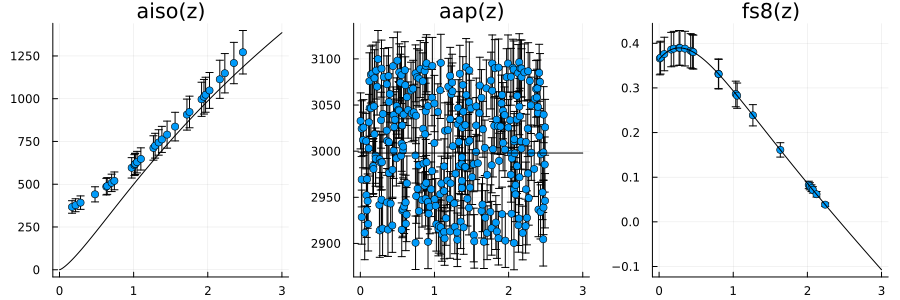

In [91]:
p1 = plot(fakedataaiso.z, fakedataaiso.data, yerr=aiso_err, seriestype=:scatter,title="aiso(z)", legend=false)
p2 = plot(fakedataaap.z, fakedataaap.data, yerr=aap_err, seriestype=:scatter, title="aap(z)", legend=false)
p3 = plot(fakedatafs8.z, fakedatafs8.data, yerr=fs8_err, seriestype=:scatter, title="fs8(z)", legend=false)

plot!(p1, z_integ1, a_iso(z_integ1, cosmo1.cpar.h, rd_fid, ez_test), color=:black)
plot!(p2, z_integ1, a_ap(z_integ1, cosmo1.cpar.h, ez_test), color=:black)
plot!(p3, z_integ1, fs8_from_ez(z_integ1, cosmo1.cpar.Ωm, cosmo1.cpar.σ8, cosmo1.cpar.h, ez_test, eltype(ez_test)), color=:black)

plot(p1, p2, p3, layout=(1,3), size=(900,300))

## LCDM analysis

In [92]:
@model function LCDM_model(data, data_cov)
    # Priors
    omegam_pr ~ Uniform(0.1, 0.5)
    h0_pr ~ Uniform(0.6, 0.8)
    s8_pr ~ Uniform(0.6, 0.9)
    rd_pr ~ Uniform(90,110)

    # Create cosmology
    cosmo_pr = LimberJack.Cosmology(Ωm=cosmo1.cpar.Ωm, Ωb=cosmo1.cpar.Ωb, h=cosmo1.cpar.h, σ8=s8_pr);
    
    # Model predictions
    ez_model = Ez(cosmo_pr, z_integ1)
    dv_rd_model = dv(z_integ1, h0_pr, ez_model) ./ rd_pr
    dh_dm_model = dh(z_integ1, h0_pr, ez_model) ./ dm_from_ez(z_integ1, h0_pr, ez_model)
    fs8_model = fs8_from_ez(z_integ1, omegam_pr, s8_pr, h0_pr, ez_model, eltype(ez_model))

    # Create interpolators
    dvrd_itp = LinearInterpolation(z_integ1, dv_rd_model, extrapolation_bc=Line())
    dhdm_itp = LinearInterpolation(z_integ1, dh_dm_model, extrapolation_bc=Line())
    fs8_itp = LinearInterpolation(z_integ1, fs8_model, extrapolation_bc=Line())

    dvrd_theory := dvrd_itp(fakedataaiso.z)
    dhdm_theory := dhdm_itp(fakedataaap.z)
    fs8_theory := fs8_itp(fakedatafs8.z)

    theory = [dvrd_theory;dhdm_theory;fs8_theory]

    # Likelihood
    data .~ MvNormal(theory, data_cov)
end

LCDM_model (generic function with 2 methods)

In [93]:
cond_LCDM_model = LCDM_model(data_obs, covariance_obs)
chain_LCDM = sample(cond_LCDM_model, NUTS(20, 0.65), 100)

Sampling   0%|                                          |  ETA: N/A
┌ Warning: failed to find valid initial parameters in 10 tries; consider providing explicit initial parameters using the `initial_params` keyword
└ @ Turing.Inference /Users/vis/.julia/packages/Turing/QN7BL/src/mcmc/hmc.jl:192
Sampling 100%|██████████████████████████████████████████| Time: 0:00:26


InterruptException: InterruptException:

In [ ]:
# lcdm chains
hzdata_lcdm = group(chain_LCDM, :dvrd_theory).value.data[:,:,1];
chidata_lcdm = group(chain_LCDM, :dhdm_theory).value.data[:,:,1];
fs8data_lcdm = group(chain_LCDM, :fs8_theory).value.data[:,:,1];

# mean and standard deviation - lcdm
hz_lcdm_m, hz_lcdm_s = mean(hdata_lcdm, dims=1), std(hdata_lcdm, dims=1); 
dm_lcdm_m, dm_lcdm_s = mean(chidata_lcdm, dims=1), std(chidata_lcdm, dims=1); 
fs8_lcdm_m, fs8_lcdm_s = mean(fs8data_lcdm, dims=1), std(fs8data_lcdm, dims=1); 

In [ ]:
plot(fakedataaiso.z, fakedataaiso.data, yerr=aiso_err, label="Data H(z)", ms=2, seriestype=:scatter)
plot!(fakedataaiso.z, vec(hz_lcdm_m), label=" H(z) LCDM mean")
plot!(fakedataaiso.z, vec(hz_lcdm_m .- hz_lcdm_s),  fillrange = vec(hz_lcdm_m .+ hz_lcdm_s), fillalpha=0.2, c=1, label="H(z) LCDM standard deviation")

In [ ]:
plot(fakedataaap.z, fakedataaap.data, yerr=aap_err, label="Data chi", ms=2, seriestype=:scatter)
plot!(fakedataaap.z, vec(dm_lcdm_m), label="Chi LCDM mean")
plot!(fakedataaap.z, vec(dm_lcdm_m .- dm_lcdm_s),  fillrange = vec(dm_lcdm_m .+ dm_lcdm_s), fillalpha=0.2, c=1, label="Chi LCDM standard deviation")

In [ ]:
plot(fakedatafs8.z, fakedatafs8.data, yerr=fs8_err, label="Data fs8", ms=2, seriestype=:scatter)
plot!(fakedatafs8.z, vec(fs8_lcdm_m), label="fs8 lcdm")
plot!(fakedatafs8.z, vec(fs8_lcdm_m .- fs8_lcdm_s),  fillrange = vec(fs8_lcdm_m .+ fs8_lcdm_s), fillalpha=0.2, c=1, label="fs8 lcdm standard deviation")

## GP modelling - priors

In [ ]:
zlat = range(0, 3.0, length=30); # latent variable space
z_integ = cosmo1.settings.zs; # integral variable space

In [ ]:
function model_latent_GP(eta, l, v; omega_m=cosmo1.cpar.Ωm, sigma_8=cosmo1.cpar.σ8, h_0 = cosmo1.cpar.h,
                         x=zlat, z=z_obs, data_cov=covariance_obs)
    # Dimensions of predictors .
    kernel = sqexp_cov_fn(x; eta=eta, l=l)
    cpar = CosmoPar(Ωm=omega_m,  Ωb=cosmo1.cpar.Ωb, h=h_0, σ8=sigma_8)
    mean_ex = Ez(cpar, x)
    # a latent GP is carried out using a Wiener filter
    ex = latent_GP(mean_ex, v, kernel)
    # transforms hx from x space to z space
    ez =  conditional(x, z, ex, sqexp_cov_fn;
                     eta=eta, l=l)
    return ex, ez
end

hx is the GP realisation of the hubble parameter. hz transforms hx from the latent space to another parameter space (integral or observation).

In [ ]:
N_samples = 100
# data parameter space conditional
exs1=zeros(N_samples, 30) #latent variable chain
ezs1=zeros(N_samples, length(z_obs)) #observed variable chain
# pick 100 random hyperparameter combinations, and compute the GP realisation of them in both latent and conditional space.
for i in 1:N_samples
    v = rand(MvNormal(zeros(length(zlat)), ones(length(zlat))))
    exs1[i, :], ezs1[i, :] = model_latent_GP(0.1, 0.3, v)
end
y_m1, y_s1 = mean(ezs1, dims=1), std(ezs1, dims=1); #observed space
gp_m1, gp_s1 = mean(exs1, dims=1), std(exs1, dims=1); #latent space


In [ ]:
# integral parameter space conditional
exs2=zeros(N_samples, length(zlat))
ezs2=zeros(N_samples, length(z_integ))
hz_pr=zeros(N_samples, length(z_integ))
dm_pr=zeros(N_samples, length(z_integ))
fs8_pr=zeros(N_samples, length(z_integ))

for i in 1:N_samples
    v = rand(MvNormal(zeros(length(zlat)), ones(length(zlat))))
    h_pr = rand(Uniform(0.6, 0.8))
    s8_pr = rand(Uniform(0.7, 0.9))
    omegam_pr = rand(Uniform(0.25,0.35))
    exs2[i, :], ezs2[i, :] = model_latent_GP(0.1, 0.3, v; z=z_integ, sigma_8=s8_pr)
    hz_pr[i, :] = hz_from_ez(z_integ, h_pr, ezs2[i, :])
    dm_pr[i, :] = dm_from_ez(z_integ, h_pr, ezs2[i, :])
    fs8_pr[i, :] = fs8_from_ez(z_integ, omegam_pr, s8_pr, h_pr, ezs2[i, :], eltype(ezs2[i, :]))
end

y_m2, y_s2 = mean(ezs2, dims=1), std(ezs2, dims=1); #integral space
gp_m2, gp_s2 = mean(exs2, dims=1), std(exs2, dims=1); #latent space

hz_m2, hz_s2 = mean(hz_pr, dims=1), std(hz_pr, dims=1); 
chi_m2, chi_s2 = mean(dm_pr, dims=1), std(dm_pr, dims=1);
fs8_m2, fs8_s2 = mean(fs8_pr, dims=1), std(fs8_pr, dims=1);

In [ ]:
# prior model predictions
hz_itp2 = LinearInterpolation(z_integ, vec(hz_m2), extrapolation_bc=Line());
dm_itp2 = LinearInterpolation(z_integ, vec(chi_m2), extrapolation_bc=Line());
fs8_itp2 = LinearInterpolation(z_integ, vec(fs8_m2), extrapolation_bc=Line());

In [ ]:
# integral space hz plot
plot(fakedatahz.z, fakedatahz.data, yerr=hz_err, label="Data hz", ms=2, seriestype=:scatter)
plot!(z_integ, vec(hz_m2), label="hz mean")
plot!(z_integ, vec(hz_m2 .- hz_s2),  fillrange = vec(hz_m2 .+ hz_s2), fillalpha=0.2, c=1, label="hz standard deviation")

In [ ]:
# plotting chi data 
plot(fakedatadm.z, fakedatadm.data, yerr=dm_err, label="Data chi", ms=2, seriestype=:scatter)
plot!(z_integ, vec(chi_m2), label="chi mean")
plot!(z_integ, vec(chi_m2 .- chi_s2),  fillrange = vec(chi_m2 .+ chi_s2), fillalpha=0.2, c=1, label="chi standard deviation")

In [ ]:
# plotting fs8 data 
plot(fakedatafs8.z, fakedatafs8.data, yerr=fs8_err, label="Data fs8", ms=2, seriestype=:scatter)
plot!(z_integ, vec(fs8_m2), label="fs8 mean")
plot!(z_integ, vec(fs8_m2 .- fs8_s2),  fillrange = vec(fs8_m2 .+ fs8_s2), fillalpha=0.2, c=1, label="fs8 standard deviation")

## GP modelling - posteriors

In [ ]:
@model function stats_model(y; int_grid=z_integ, X=zlat, data_x=z_obs, data_cov=covariance_obs)
    # Priors, parameters
    eta2 = 0.1
    l2 = 0.3
    v_po ~ MvNormal(zeros(length(X)), ones(length(X)))
    omegam_po ~ Uniform(0.25, 0.35)
    s8_po ~ Uniform(0.7, 0.9)
    h_po ~ Uniform(0.6, 0.8)

    kernel = sqexp_cov_fn(X, eta=eta2, l=l2)
    cpar = CosmoPar(Ωm=cosmo1.cpar.Ωm, Ωb=cosmo1.cpar.Ωb, h=cosmo1.cpar.h, σ8=s8_po)
    mean_ez = Ez(cpar, X)
    ez_latent = latent_GP(mean_ez, v_po, kernel)
    ez_gp = conditional(X, int_grid, ez_latent, sqexp_cov_fn; eta=eta2, l=l2) # converting from latent space to integral space
    
    # sampling over parameters
    hz = hz_from_ez(int_grid, h_po, ez_gp);
    chi = dm_from_ez(int_grid, h_po, ez_gp);
    fs8 = fs8_from_ez(int_grid, omegam_po, s8_po, h_po, ez_gp, eltype(ez_gp));

    hz_interp = LinearInterpolation(int_grid, hz, extrapolation_bc=Line())
    chi_interp = LinearInterpolation(int_grid, chi, extrapolation_bc=Line())
    fs8_interp = LinearInterpolation(int_grid, fs8, extrapolation_bc=Line())

    hdata := hz_interp(fakedatahz.z)
    chidata := chi_interp(fakedatadm.z)
    fs8data := fs8_interp(fakedatafs8.z)
    datay = [hdata;chidata;fs8data]

    y = MvNormal(datay, data_cov) # FIGURE THIS OUT

end

In [ ]:
chain_gp = sample(stats_model(data_obs), NUTS(20, 0.65), 100)

In [ ]:
hdata_p = group(chain_gp, :hdata).value.data[:,:,1];
chidata_p =  group(chain_gp, :chidata).value.data[:,:,1];
fs8data_p =  group(chain_gp, :fs8data).value.data[:,:,1];

In [ ]:
v_p = group(chain_gp, :v_po).value.data[:, :, 1];
omegam_p = group(chain_gp, :omegam_po).value.data[:, :, 1];
s8_p = group(chain_gp, :s8_po).value.data[:, :, 1];

In [ ]:
hpmean, hps = mean(hdata_p, dims=1), std(hdata_p, dims=1);
chipmean, chips = mean(chidata_p, dims=1), std(chidata_p, dims=1);
fs8pmean, fs8ps = mean(fs8data_p, dims=1), std(fs8data_p, dims=1);

In [ ]:
plot(fakedatahz.z, fakedatahz.data, yerr=hz_err, label="Data hz", ms=2, seriestype=:scatter)
plot!(fakedatahz.z, vec(hpmean), label="hz GP mean")
plot!(fakedatahz.z, vec(hpmean .- hps),  fillrange = vec(hpmean .+ hps), fillalpha=0.2, c=1, label="GP standard deviation")

In [ ]:
plot(fakedatadm.z, fakedatadm.data, yerr=dm_err, label="Data chi", ms=2, seriestype=:scatter)
plot!(fakedatadm.z, vec(chipmean), label="chi mean")
plot!(fakedatadm.z, vec(chipmean .- chips),  fillrange = vec(chipmean .+ chips), fillalpha=0.2, c=1, label="chi standard deviation")

In [ ]:
plot(fakedatafs8.z, fakedatafs8.data, yerr=fs8_err, label="Data fs8", ms=2, seriestype=:scatter)
plot!(fakedatafs8.z, vec(fs8pmean), label="fs8 mean")
plot!(fakedatafs8.z, vec(fs8pmean .- fs8ps),  fillrange = vec(fs8pmean .+ fs8ps), fillalpha=0.2, c=1, label="fs8 standard deviation")